# Retrieving and Aggregating AORC Data for a Spatial Domain

**Authors:** 

<ul style="line-height:1.5;">
<li>Ayman Nassar <a href="mailto:ayman.nassar@usu.edu">(ayman.nassar@usu.edu)</a></li>
<li>Pabitra Dash <a href="mailto:pabitra.dash@usu.edu">(pabitra.dash@usu.edu)</a></li>
<li>Homa Salehabadi <a href="mailto:homa.salehabadi@usu.edu">(homa.salehabadi@usu.edu)</a></li>
<li>David Tarboton <a href="mailto:david.tarboton@usu.edu">(david.tarboton@usu.edu)</a></li>
<li>Anthony Castronova <a href="acastronova@cuahsi.org">(acastronova@cuahsi.org)</a></li>
</ul>

**Last Updated:** 2/14/2025

**Purpose:**

This notebook provides code examples for retrieving NOAA Analysis of Record for Calibration (AORC) data from Amazon Web Services (AWS). It is intended to make it easy for researchers to access data for a specific spatial domain specified by a shapefile. It also allows for data aggregation at different time scales than what NOAA originally provided.

**Audience:**

Researchers who are familiar with Jupyter Notebooks, basic Python and basic hydrologic data analysis.

**Description:**

This notebook takes as inputs a shapefile of a specific location, start and end dates for the desired period, a variable name, and a preferred time aggregation interval. It then retrieves data from AWS, aggregates it over the specified time interval and individual shapes within the input shapefile, saves it as a CSV file, and visualize the data. 

**Data Description:**

This notebook uses AORC data developed and published by NOAA on Amazon Web Services (AWS) as described in detail in this registry of open data entry <https://registry.opendata.aws/noaa-nws-aorc/>. The AORC dataset is a gridded record of near-surface weather conditions covering the continental United States and Alaska and their hydrologically contributing areas. It is defined on a latitude/longitude spatial grid with a mesh length of 30 arc seconds (~800 m), and a temporal resolution of one hour. This notebook uses the Zarr format files of version 1.1 of the AORC data. Zarr is a format for storage of chunked, compressed, N-dimensional arrays, designed to support storage using distributed systems such as cloud object stores (<https://zarr.dev/>).


**Software Requirements:**

This notebook has been tested using Python v3.11.8 using the following library versions:

 >  numpy: 1.26.4  
    geopandas: 0.14.4  
    matplotlib: 3.8.3  
    xarray: 2024.3.0  
    s3fs: 2024.3.1  
    fsspec: 2024.3.1  
    contextily: 1.6.2  
    exactextract: 0.2.0  
    zarr: 2.17.2  

It also uses code from aorc_utils.py and environment specifications from requirements.txt, which accompany this notebook.

### 1. Prepare the Python Environment

Use the following command to ensure that all dependencies are installed in your environment. Note, these library versions have been pinned and tested for `Python 3.11.8`.

In [1]:
!pip install -r requirements.txt

Import the libraries needed to run this notebook:

In [2]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
from aorc_utils import get_conus_bucket_url, load_dataset, get_variable_code, get_aggregation_code, display_shapefile_map, da_animate
import pyproj
from exactextract import exact_extract

import warnings
warnings.filterwarnings("ignore") # Suppress a warning for potential future changes in GDAL (Geospatial Data Abstraction Library).

### 2. Set Inputs

Use the cells in this section of the notebook to set the input values that specify the data to retrieve.  Note that a shapefile holding Great Salt Lake subbasins has been provided with this resource. Add your own shapefile and provide the path to its location to retrieve data for a different location.

In [3]:
# Start date - In Year-Month-Day format the earliest start date can be '1979-02-01'
start_datetime = '2020-01-01'

# End date - In Year-Month-Day format the latest end date can be '2023-01-31'
end_datetime = '2020-12-31'

# File path to the shape file to used as an input
shapefile_path = "./GSLSubbasins/GSLSubbasins.shp"

# Basin name (this will be used on the maps and plots)
basin_name = "Great Salt Lake Basin"

The followings are valid variables to retrieve data:

|Common Name|Variable Name|Description|
|---|---|---|
|Total Precipitation| APCP_surface | Hourly total precipitation (kgm-2 or mm) |
|Air Temperature| TMP_2maboveground | Temperature (at 2 m above-ground-level (AGL)) (K) |
|Specific Humidity| SPFH_2maboveground | Specific humidity (at 2 m AGL) (g g-1) |
|Downward Long-Wave Radiation Flux| DLWRF_surface | longwave (infrared) radiation flux (at the surface) (W m-2) |
|Downward Short-Wave Radiation Flux| DSWRF_surface | Downward shortwave (solar) radiation flux (at the surface) (W m-2) |
|Pressure| PRES_surface | Air pressure (at the surface) (Pa) |
|U-Component of Wind| UGRD_10maboveground) | (west to east) - components of the wind (at 10 m AGL) (m s-1) |
|V-Component of Wind| VGRD_10maboveground) | (south to north) - components of the wind (at 10 m AGL) (m s-1)|

In [4]:
# User-defined inputs - this can be any variable name as listed above
variable_name = 'Total Precipitation'

# User-defined aggregation interval - valid values are 'hour','day','month','year'
agg_interval = 'month'

### 3. Read Shapefile and Display Map

In [5]:
# Read the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

The following visualisation is optional and not necessary for the rest of calculations.

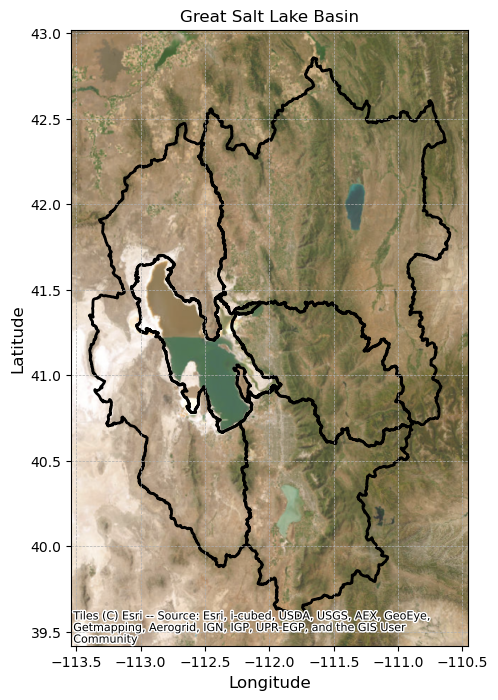

In [6]:
# Display shapefile and map (optional)
display_shapefile_map(gdf, basin_name)

### 4. Virtually Load the Data Array 
This block of code maps the input variable and aggregation interval onto the variable encoding used in the Zarr bucket storage.  It then loads the virtual xarray dataset for the variable of interest. 

In [7]:
# Get the variable code
variable_code = get_variable_code(variable_name)

# Get the S3 bucket data file URL
url = get_conus_bucket_url(variable_code)
ds = load_dataset(url)

# Print the unit of the slected variable in AORC dataset
print(f"The unit of {list(ds.data_vars)[0]} is {ds[list(ds.data_vars)[0]].attrs.get('units', 'No units specified')}")

# Print the dataset (ds) of selected variable
ds

The unit of RAINRATE is mm s^-1


<xarray.Dataset> Size: 27TB
Dimensions:   (time: 385704, y: 3840, x: 4608)
Coordinates:
  * time      (time) datetime64[ns] 3MB 1979-02-01 ... 2023-01-31T23:00:00
  * x         (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y         (y) float64 31kB -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    RAINRATE  (time, y, x) float32 27TB dask.array<chunksize=(672, 350, 350), meta=np.ndarray>
    crs       |S1 1B ...
Attributes:
    NWM_version_number:   v2.1
    model_configuration:  AORC
    model_output_type:    forcing

### 4. Check Coordinate Reference System (CRS)

Use the following cell to check the Coordinate Reference System (CRS) of the shapefile and reproject it if the shapefile CRS does not match the dataset CRS. This ensures that spatial data extractions, calculations, and visualizations are correctly aligned on the same coordinate system. 
The AORC data coordinate system is a Lambert Conformal Conic projection used by the National Water Model. Curious users could examine ds.crs.esri_pe_string to see details.

In [8]:
# Dataset CRS
crs_dataset = pyproj.CRS(ds.crs.esri_pe_string)
print(f'\033[1mDataset CRS ---> \033[0m {crs_dataset}')
print(f'\033[1mOriginal Shapefile CRS ---> \033[0m {gdf.crs}')

# Reproject shapefile if needed
if gdf.crs != crs_dataset:
    gdf = gdf.to_crs(crs_dataset)
print(f'\033[1mReprojected Shapefile CRS ---> \033[0m {gdf.crs}')

Dataset CRS --->  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DATUM["D_Sphere",SPHEROID["Sphere",6370000.0,0.0]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["central_meridian",-97.0],PARAMETER["standard_parallel_1",30.0],PARAMETER["standard_parallel_2",60.0],PARAMETER["latitude_of_origin",40.0],UNIT["Meter",1.0]];-35691800 -29075200 10000;-100000 10000;-100000 10000;0.001;0.001;0.001;IsHighPrecision
Original Shapefile CRS --->  EPSG:4269
Reprojected Shapefile CRS --->  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DATUM["D_Sphere",SPHEROID["Sphere",6370000.0,0.0]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["central_meridian",-97.0],PARAMETER["standard_parallel_1",30.0],PARAMETER["standard_parallel_2",60.0],PARAMET

In [9]:
# Compute area in the projected CRS
gdf['Projected_Area_km2'] = gdf['geometry'].area/ 10**6  # Area in square kilometers
total_area = gdf['Projected_Area_km2'].sum()
print(f'Total {basin_name} Area is {total_area} km2')
gdf

Total Great Salt Lake Basin Area is 51435.49383195532 km2


,name,Shape_Leng,Shape_Area,geometry,Projected_Area_km2
0,Bear,12.232769,2.111604,"POLYGON ((-1147712.291 412292.373, -1147684.59...",18194.451240
1,West Desert,13.215229,1.569809,"MULTIPOLYGON (((-1230002.571 231578.723, -1229...",13706.711543
2,Great Salt Lake,6.955759,0.485716,"POLYGON ((-1264434.320 308545.241, -1264425.10...",4240.298840
3,Jordan,7.290251,1.043635,"POLYGON ((-1211256.126 214402.991, -1211265.14...",9258.014381
4,Weber,5.435790,0.689935,"POLYGON ((-1199088.151 265284.315, -1199072.84...",6036.017828


### 5. Temporal and Zonal Aggregation of Data

#### 5.1. Temporal Aggregation

The following cell extracts data for the area and temporally aggregates it to the user-defined time aggregation interval (`agg_interval`). The input AORC data has an hourly time step. The output is a DataArray called `aggregated_subset_xy`, which contains the temporally aggregated subset over the entire area.

In [10]:
agg_code = get_aggregation_code(agg_interval)

# Bounding box extraction (for efficiency, we first subset and aggregate the dataset to the bounding box, then clip the data for the basin.) 
bounding_box = box(*gdf.total_bounds)
x_min, y_min, x_max, y_max = bounding_box.bounds

if variable_code == 'precip':
    unit = f"mm/{agg_interval}"
    # Clip dataset to bounding box first for efficiency
    ds_subset = ds['RAINRATE'].sel(y=slice(y_min, y_max), x=slice(x_min, x_max))
    ds_aggregated = ds_subset.loc[dict(time=slice(start_datetime, end_datetime))].resample(time=agg_code).sum() * 3600

else:
    unit = ds[variable_code.upper()].attrs.get('units', 'No units specified')
    # Clip dataset to bounding box first for efficiency
    ds_subset = ds[variable_code.upper()].sel(y=slice(y_min, y_max), x=slice(x_min, x_max))
    ds_aggregated = ds_subset.loc[dict(time=slice(start_datetime, end_datetime))].resample(time=agg_code).mean()

# Ensure dataset has CRS for exact_extract
ds_aggregated.rio.write_crs(gdf.crs, inplace=True)

# Clip data for entire basin
geom_union = gdf.unary_union
aggregated_subset_xy = ds_aggregated.rio.clip([geom_union], gdf.crs, all_touched=True)
# Note: The `all_touched` parameter controls whether to include all cells that are even partially touched by the vector (all_touched = True) or only those whose 
# center falls inside the vector (all_touched = False). Set all_touched = True to ensure that every cell that intersects the vector, even if only slightly, is 
# included. We will then use exactextract library to extract the exact zonal statistics. 

aggregated_subset_xy

<xarray.DataArray 'RAINRATE' (time: 12, y: 345, x: 244)> Size: 4MB
dask.array<where, shape=(12, 345, 244), dtype=float32, chunksize=(1, 233, 176), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 2kB -1.321e+06 -1.32e+06 ... -1.079e+06 -1.078e+06
  * y            (y) float64 3kB 6.85e+04 6.95e+04 ... 4.115e+05 4.125e+05
  * time         (time) datetime64[ns] 96B 2020-01-31 2020-02-29 ... 2020-12-31
    spatial_ref  int64 8B 0

#### 5.2. Zonal Aggregation

Use `exactextract` for zonal aggregation. `exactextract` is a library for extracting and summarizing the values in the portion of a raster dataset that is covered by a polygon, often referred to as zonal statistics. Please refer to <https://isciences.github.io/exactextract/index.html> for more information.

The following cell computes the mean for each subbasin separately, as well as for the entire basin. The output is a dataframe called `aggregated_subset`, with time in the first column followed by values for the variable of interest for each subbasin and the entire basin.

In [11]:
%%time

# Compute mean for each subbasins using exactextract
ds_zonal_agg_subbasins = exact_extract(aggregated_subset_xy, gdf, "mean", include_cols=["name"], output='pandas')

# The following lines will organaize the output dataframe to make it easier to analyze and plot,
# and also calculate the mean for the entire basin based on the means of the subbasins.

ds_zonal_agg = ds_zonal_agg_subbasins.copy()

# Format time labels
time_coords = pd.to_datetime(aggregated_subset_xy['time'].values)
formatted_dates = time_coords.strftime('%Y-%m-%d' if agg_interval == 'day' else '%Y-%m' if agg_interval == 'month' else '%Y')

# Rename the columns to match time periods
ds_zonal_agg.columns = ['subbasin'] + list(formatted_dates)  

# Set "subbasin" as index for easier plotting
ds_zonal_agg.set_index('subbasin', inplace=True)

# Transpose data for plotting (time as index, subbasins as columns)
aggregated_subset = ds_zonal_agg.T 

# Calculate mean values for the entire basin based on subbasins. This will proceed only if there are more than one subbasin. 
if len(gdf) > 1: # Check if there are more than one subbasin in the gdf
    subbasin_area = gdf['Projected_Area_km2']
    # Multiply the values by the respective subbasin areas
    weighted_values = aggregated_subset.multiply(subbasin_area.values, axis=1)
    # Calculate the weighted mean for the entire basin
    weighted_mean_entire_basin = weighted_values.sum(axis=1) / total_area
    # Add the "Entire Basin" column
    aggregated_subset['Entire Basin'] = weighted_mean_entire_basin

# Print the unit
print(f"The unit is {unit}")
# Display the result
aggregated_subset

The unit is mm/month
CPU times: user 1min 39s, sys: 1min 1s, total: 2min 40s
Wall time: 1min 13s


subbasin,Bear,West Desert,Great Salt Lake,Jordan,Weber,Entire Basin
2020-01,75.647234,27.364196,27.650941,67.039712,84.459035,58.308610
2020-02,41.593739,14.166215,11.276183,43.730918,47.666592,32.882735
2020-03,58.108643,25.572237,25.651006,58.590123,63.702895,47.505602
2020-04,34.262144,12.936728,8.404596,18.840509,22.055864,22.239394
2020-05,30.431898,20.932240,15.513296,12.056024,20.933652,22.248364
2020-06,73.380354,45.163756,50.565846,39.557584,61.021456,56.442102
2020-07,12.749813,7.832441,5.875331,8.829511,4.585579,9.208979
2020-08,3.790040,3.539721,2.969221,1.335913,3.236284,3.148958
2020-09,13.032833,11.569833,8.497081,7.347917,5.542901,10.366848
2020-10,14.072903,2.394281,3.545496,3.959480,8.747639,7.647603


### 6. Save the the Temporally and Spatially Aggregated Data as a CSV File

In [12]:
# Specify the file path where you want to save the CSV file
file_path = f"{variable_name}_over_area.csv"

# Save the DataFrame to a CSV file
aggregated_subset.to_csv(file_path, index=True)  

### 7. Plot the Data (Optional)

Use the following cell to plot time series of temporally and spatially aggregated data over the subbasins and the entire basin. 

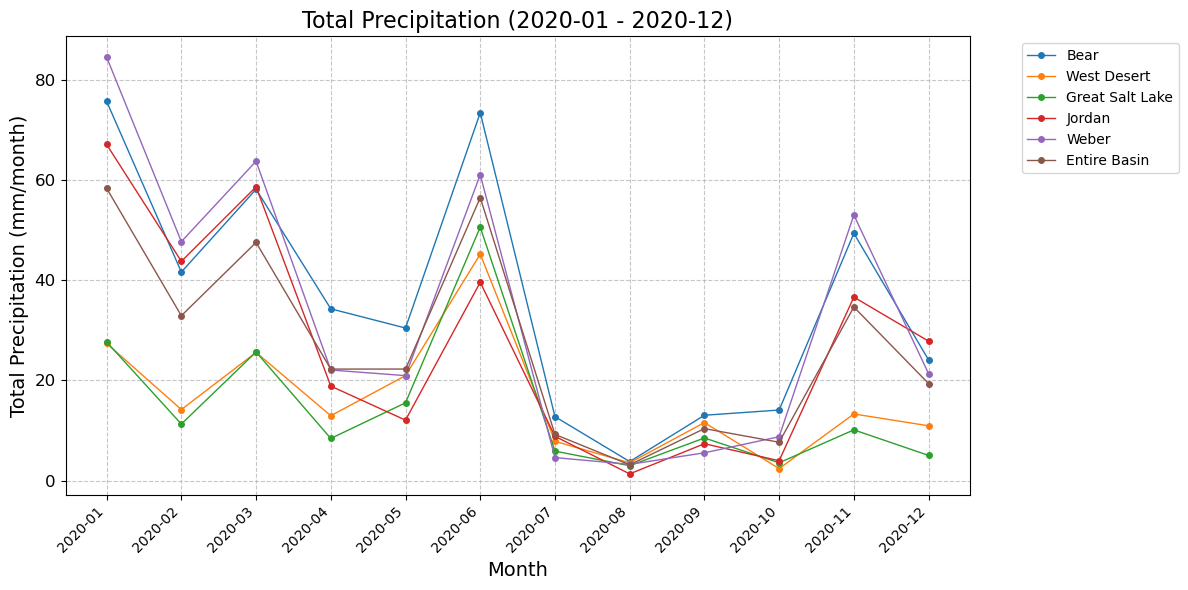

In [13]:
# Plot time series for each subbasin
plt.figure(figsize=(12, 6))

for subbasin in aggregated_subset.columns:  
    plt.plot(aggregated_subset.index, aggregated_subset[subbasin], label=subbasin, linewidth=1, marker='o', markersize=4)

plt.title(f'{variable_name} ({formatted_dates[0]} - {formatted_dates[-1]})', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(f'{agg_interval.capitalize()}', fontsize=14)
plt.ylabel(f'{variable_name} ({unit})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
if len(aggregated_subset.index) > 20 : # Show fewer labels to avoid overlap
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))  

# Save and display the plot
plt.savefig(f'{variable_name}_over_area.png', dpi=300)
plt.show()

Use the following cell to visualize temporally aggregated subset over the entire area as an animated plot: 

In [14]:
da_animate(aggregated_subset_xy, gdf, variable_name, unit, agg_interval)